In [1]:
import numpy as np
import cv2 as cv
from numpy import all, any, arctan2, cos, sin, exp, dot, log, logical_and, roll, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from matplotlib import pyplot as plt
from functools import cmp_to_key

In [2]:
raw_image = cv.imread('box_in_scene.png', 0).astype(np.float32)
SIGMA, PRE_BLUR= 1.6, 0.5
BUM_INTERVALS = 3
IMAGE_BORDER_WIDTH = 5

# 1 构建高斯差分尺度空间（DOG）
## 1.1 构建高斯金字塔
1. 升采样：为了尽可能多的保留原始图像的信息，一般首先要对原始图像进行扩大两倍的采样及就是升采样，从而生成Octave-1的图像，原因是因为在相机拍摄的过程中时，图像已经被进行了一次降采样。Lowe在论文中给出的建议是，第1层的尺度建议定为1.6，原图的尺度建议定为0.5，因为取景器（相机），一般会做这样一个处理以维持图片质量。这样就带来了一个问题：因为原图是由0.5的平滑器处理过的，相当于一部分信息已经丢失了。这个时候需要引入刚才到的升采样操作，将原图放大为原来的2倍。由这张放大的图片进行卷积生成第一层第一张图片，才能保证最大程度上利用原图信息。同时，因为第一层的尺度是1.6，但是刚才解释过，原图并不是真正的原图，此时进行卷积的图片的尺度应该是2*0.5=1。那么，此时应用在升采样后的图片上的卷积尺度就应该是$\sigma_{diff} = \sqrt{\sigma_{init}^2 - \sigma_{pre}^2}$用此尺度对升采样后的图片进行卷积，获得第一组第一层。这里升采样我直接使用了opev自带的resize函数，使用双三次插值法。

In [3]:
def generateBaseImage(image, sigma, pre_blur):
    """
    :param image: 输入图像
    :param sigma: sigma
    :param pre_blur: 预模糊（图像被照相机拍下后的模糊）
    :return: base image
    从输入图像生成基本图像，通过在两个方向上上采样2倍并模糊
    """
    ksize = (0, 0)
    scale = 2
    image = cv.resize(image, ksize, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)
    sigma_diff = np.sqrt(max((sigma ** 2) - ((2 * pre_blur) ** 2), 0.01))
    # print(f"sigma_diff: {sigma_diff}")
    img_blur = cv.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)
    return img_blur  # 现在图像的模糊度是sigma而不是assumed_blur

In [4]:
base_image = generateBaseImage(raw_image, SIGMA, PRE_BLUR)

In [5]:
print(f"base_image.shape: {base_image.shape},raw_image.shape: {raw_image.shape}")

base_image.shape: (768, 1024),raw_image.shape: (384, 512)


2. 获取octaves的数量：构建DOG的第一步就是构建高斯金字塔。具体地讲他是一个金字塔组。它由O组S层图像金字塔构成。每一层内的图像尺寸是一样的，都包含了S+3(下文中会详细说明为啥要在这里+3)个图像，同一组中的所有图像具有相同的宽度和高度，但是模糊量逐渐增加，是后一幅图片是由上一幅图片经过高斯卷积而来。而下一组图象又是由上一组图像经过降采样得到。
3. 定量化的分析：在原始的论文中遵循的规则是$O = \log_2{min(w,h)}-3$,其中，(w,h)分别表示图像的宽和高。对于尺度空间中第o组的第s层图像，其尺度为$\sigma_{s} = \sigma_{init}2^{s/S}$，其中，$\sigma_{init}$是初始的高斯模糊尺度，S是每组图像的层数,一般被设置为6-9层。因此这里我将`numIntervals`设置为3，即每组图像的层数为3+3=6层。最后可以讲组内组间尺度归为公式$2^{o-1}(\sigma,k \sigma,\dots,k^{s+2}\sigma)$，其中$k = 2^{1/s}$，同1中分析的那样，每一层之间的尺度差为$\sigma_{diff} = \sqrt{(\sigma_{init}k^{s+1})^2 - (\sigma_{init}k^s)^2}$。

In [6]:
def computeNumberOfOctaves(image_shape):
    """
    计算图像金字塔中的octaves数量
    :param image_shape: shape of base image
    """
    return int(np.round(np.log2(min(image_shape)) - 3))

In [7]:
num_octaves = computeNumberOfOctaves(base_image.shape)

In [8]:
print(f"num_octaves: {num_octaves}")

num_octaves: 7


In [9]:
def generateGaussianKernels(sigma, num_intervals):
    """
    生成每一层的高斯核列表。
    """
    S = num_intervals + 3 # 一组6层图像
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = np.zeros(S)
    gaussian_kernels[0] = sigma
    for image_index in range(1, S):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

In [10]:
gaussian_kernels = generateGaussianKernels(SIGMA, BUM_INTERVALS)
print(f"gaussian_kernels: {gaussian_kernels}")

gaussian_kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


4. 这样我们就完成了对于高斯金字塔的构建

In [11]:
def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    gaussian_images = []
    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3] # 该组的第三层图像作为下一组的基础图像
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return np.array(gaussian_images, dtype=object)

In [12]:
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)

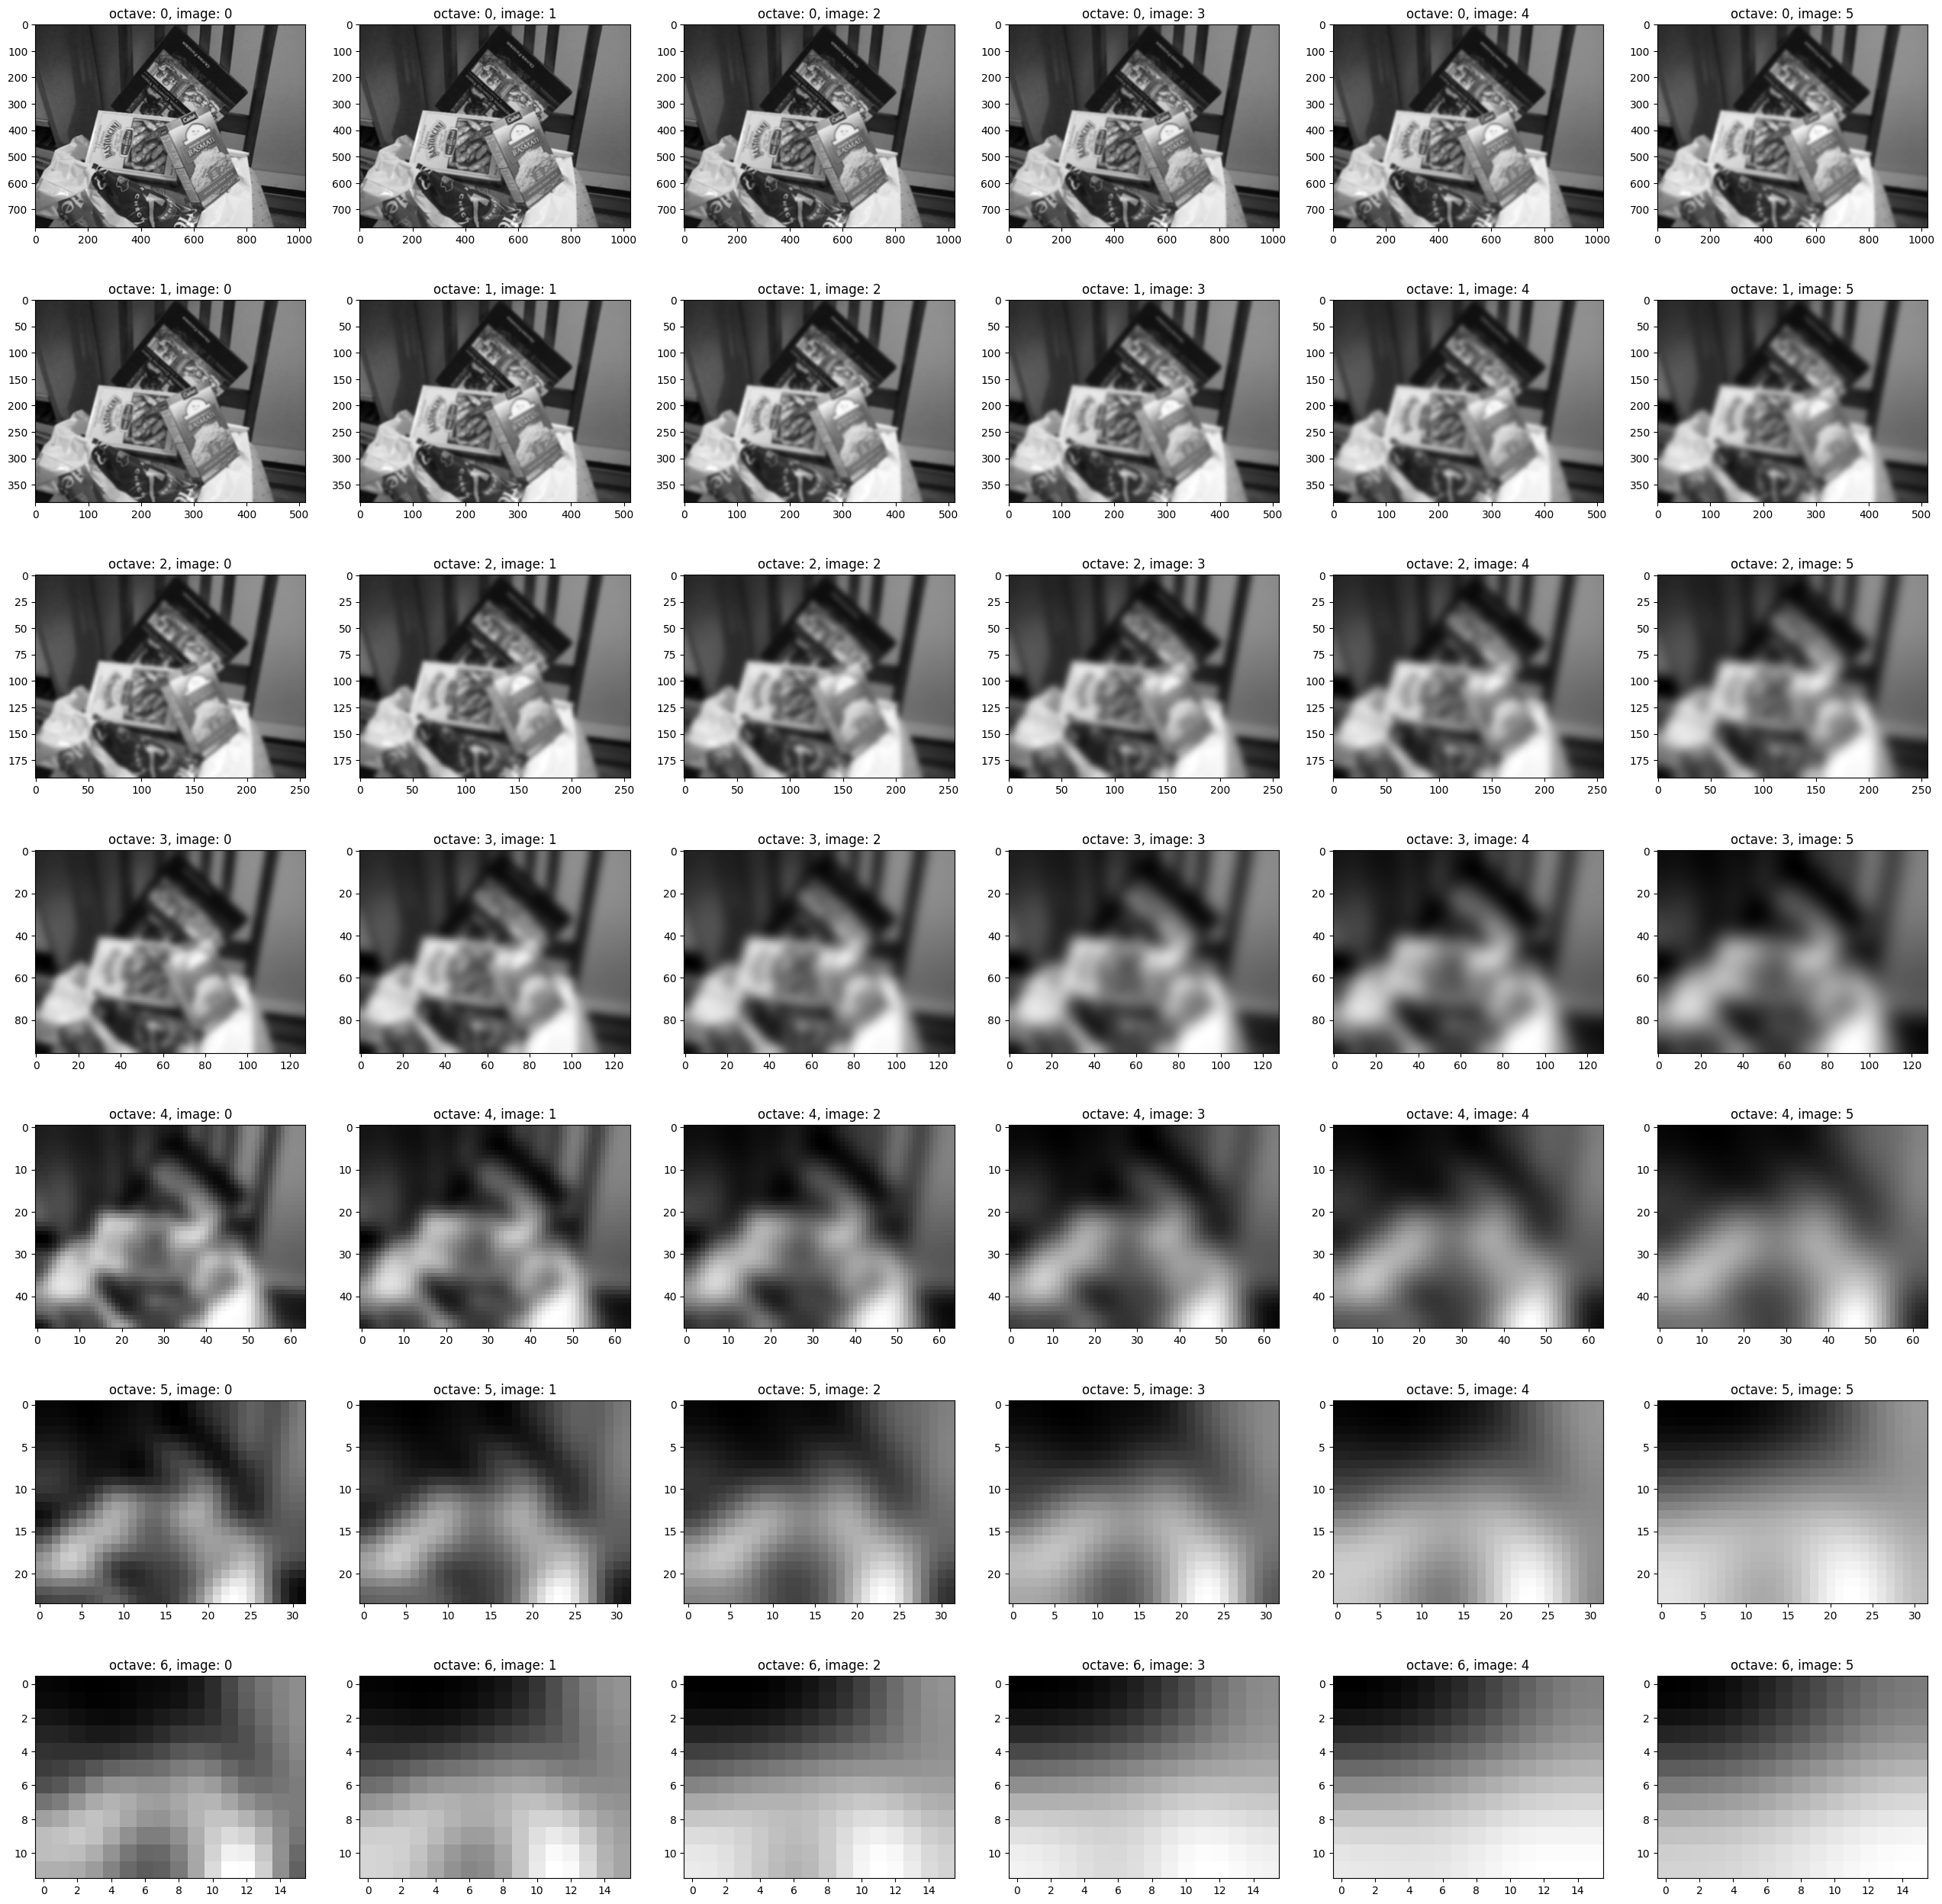

In [13]:
plt.figure(figsize=(32, 32))
for octave_index in range(num_octaves):
    for image_index in range(len(gaussian_images[octave_index])):
        plt.subplot(num_octaves, len(gaussian_images[octave_index]), octave_index * len(gaussian_images[octave_index]) + image_index + 1,aspect='equal')
        plt.imshow(gaussian_images[octave_index][image_index], cmap='gray')
        plt.title(f"octave: {octave_index}, image: {image_index}")
plt.savefig("gaussian_images.png")

## 1.2 构建DoG金字塔
1. 接下来构建高斯差分金字塔。高斯差分金字塔与高斯金字塔结构一致，生成过程是用高斯金字塔每一组内的两幅图像差分生成。公式是：
$$D(x,y,\sigma) = (G(x,y,k\sigma) -G(x,y,\sigma)) * I(x,y) = L(x,y,k\sigma) - L(x,y,\sigma)$$
论文中也给出了相应的示意图，DOG图像描绘的是目标的轮廓。
![论文中的示意图](./img/1.png)

In [14]:
def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    dog_images = []
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return np.array(dog_images, dtype=object)

In [15]:
DoG_imgs = generateDoGImages(gaussian_images)

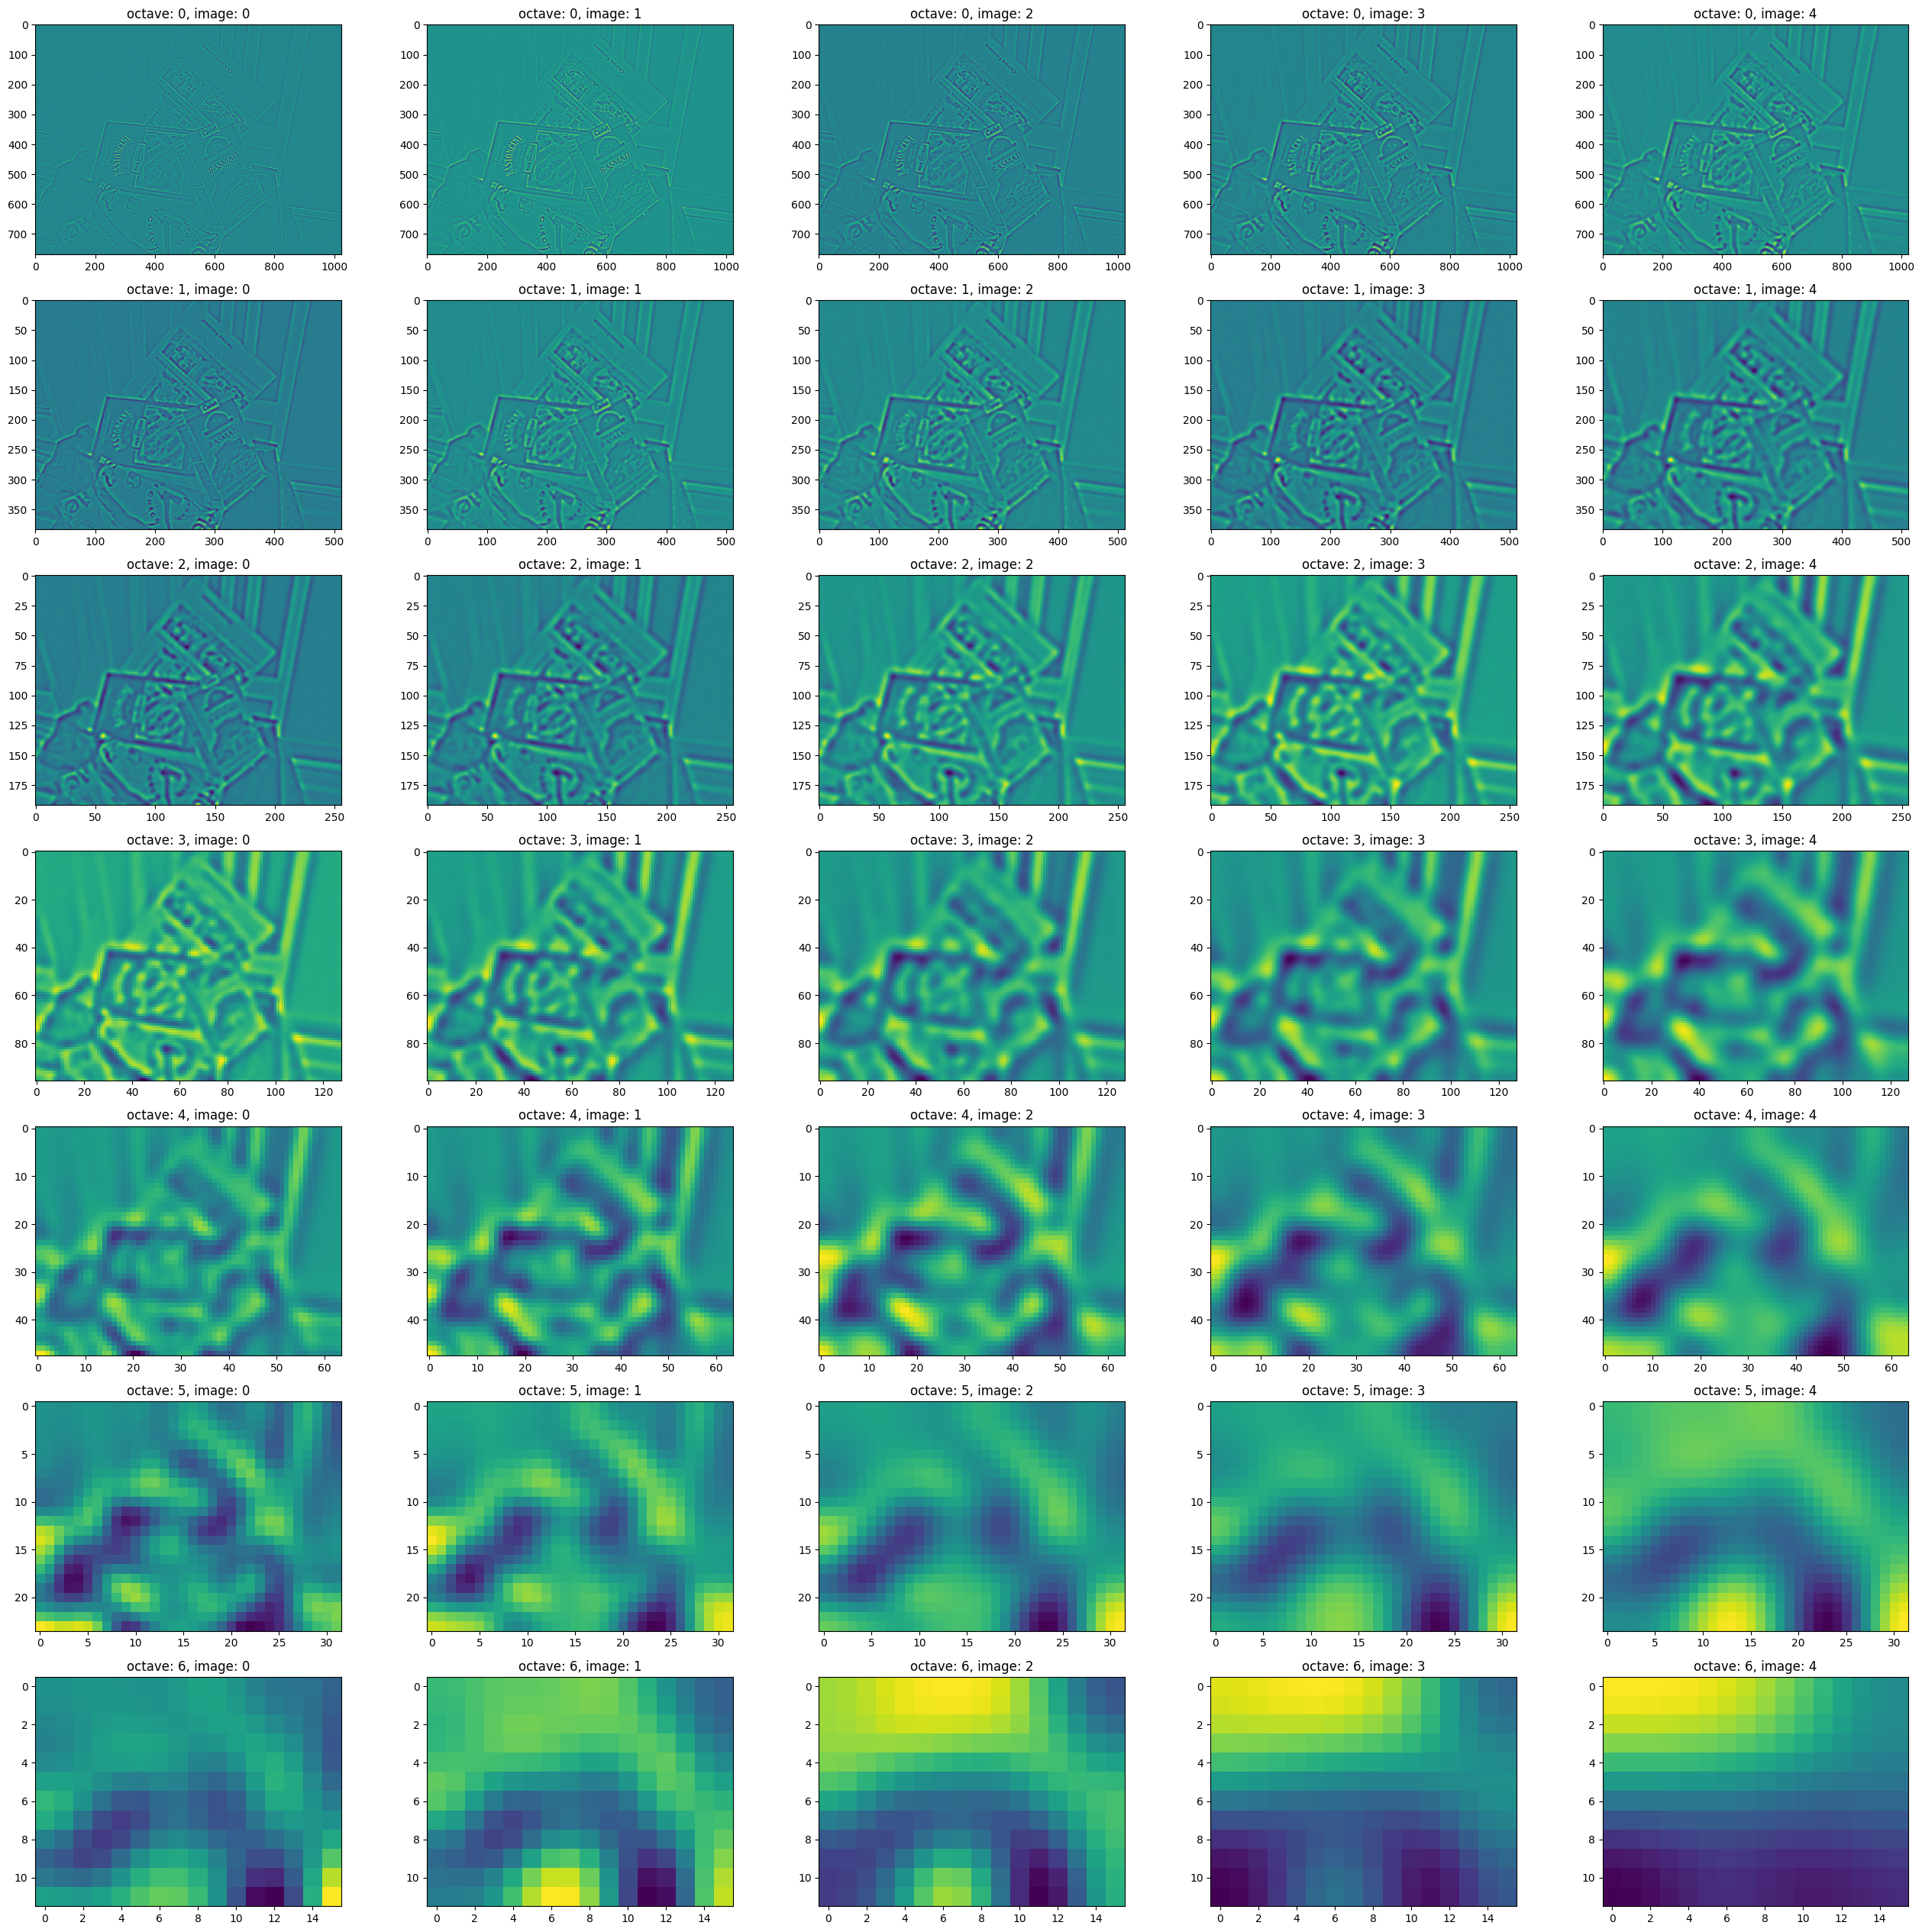

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(32, 32))
for octave_index in range(num_octaves):
    for image_index in range(len(DoG_imgs[octave_index])):
        plt.subplot(num_octaves, len(DoG_imgs[octave_index]), octave_index * len(DoG_imgs[octave_index]) + image_index + 1, aspect='equal')
        plt.imshow(DoG_imgs[octave_index][image_index])
        plt.title(f"octave: {octave_index}, image: {image_index}")
plt.show()
plt.savefig("dog_images.png")


In [18]:
DoG_imgs[0][0]

array([[ 0.25492477,  0.23550797,  0.16110992, ...,  0.20560455,
        -0.12421417, -0.28271484],
       [ 0.29083252,  0.24648666,  0.13444138, ...,  0.20193481,
        -0.09624481, -0.2378006 ],
       [ 0.35901642,  0.26070023,  0.06925583, ...,  0.1878891 ,
        -0.03668976, -0.13897705],
       ...,
       [ 0.24532318,  0.13806534, -0.0899334 , ..., -0.3156433 ,
        -0.06923294,  0.03104019],
       [-0.19132423, -0.2149849 , -0.2520504 , ...,  0.10691452,
        -0.24058533, -0.41282654],
       [-0.42826843, -0.39692688, -0.31088638, ...,  0.39282608,
        -0.24097443, -0.54415894]], dtype=float32)

In [17]:
def isPixelAnExtremum(st, nd, rd, threshold):
    """
    根据3x3x3的数组判断中心点是否是极值点，如果是极值点则返回True，否则返回False，并且极值点的阈值为threshold
    """
    c = nd[1, 1]
    # 把这个3x3x3的矩阵展开成一个一维数组，然后找出最大值和最小值
    # stacked = np.vstack((st.flatten(), nd.flatten(), rd.flatten()))
    # if abs(c) > threshold and (c == stacked.max() or c == stacked.min()):
    #     return True
    if abs(c) > threshold:
        if c > 0:
            return all(c >= st) and all(c >= rd) and all(c >= nd[0, :]) and all(c >= nd[2, :]) and c >= nd[1, 0] and c >= nd[1, 2]
        elif c < 0:
            return all(c <= st) and all(c <= rd) and all(c <= nd[0, :]) and all(c <= nd[2, :]) and c <= nd[1, 0] and c <= nd[1, 2]
    return False
import time
start = time.time()
contrast_threshold = 0.04
cnt = 0
for octave_index, dog_images_in_octave in enumerate(DoG_imgs):
    threshold = floor(0.5 * contrast_threshold / BUM_INTERVALS * 255)  # from OpenCV implementation
    print(f"\n*************octave: {octave_index}*************")
    three_zip_image = zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])
    for image_index, (first_image, second_image, third_image) in enumerate(three_zip_image):
        print(f"------------------octave: {octave_index}, image: {image_index}------------------")
        # 遍历图像进行比较
        for i in range(IMAGE_BORDER_WIDTH, first_image.shape[0] - IMAGE_BORDER_WIDTH):
            for j in range(IMAGE_BORDER_WIDTH, first_image.shape[1] - IMAGE_BORDER_WIDTH):
                i_r, i_w = i - 1, i + 2
                j_r, j_w = j - 1, j + 2
                if isPixelAnExtremum(first_image[i_r:i_w,j_r:j_w], second_image[i_r:i_w,j_r:j_w], third_image[i_r:i_w,j_r:j_w], threshold):
                    # print(f"octave: {octave_index}, image: {image_index}, pixel: ({i}, {j})")
                    cnt += 1
                    # print(f"first_image\n: {first_image[i_r:i_w,j_r:j_w]}, \nsecond_image\n: {second_image[i_r:i_w,j_r:j_w]}, \nthird_image\n: {third_image[i_r:i_w,j_r:j_w]}")
                    # break
    #         break
    #     break
    # break
end = time.time()
print(f"cnt: {cnt}, time: {end - start}")



*************octave: 0*************
------------------octave: 0, image: 0------------------
------------------octave: 0, image: 1------------------
------------------octave: 0, image: 2------------------

*************octave: 1*************
------------------octave: 1, image: 0------------------
------------------octave: 1, image: 1------------------
------------------octave: 1, image: 2------------------

*************octave: 2*************
------------------octave: 2, image: 0------------------
------------------octave: 2, image: 1------------------
------------------octave: 2, image: 2------------------

*************octave: 3*************
------------------octave: 3, image: 0------------------
------------------octave: 3, image: 1------------------
------------------octave: 3, image: 2------------------

*************octave: 4*************
------------------octave: 4, image: 0------------------
------------------octave: 4, image: 1------------------
------------------octave: 4, im

# 2. 构建空间极值点

## 2.1 局部极值点的检测（Local extrema detection）

1. 极值点的选取是SIFT算法的核心。论文中提到，极值点的选取是通过对DOG图像进行极值点的选取，然后再对DOG图像进行插值，得到更精确的极值点。这里先来看看局部极值点的选取。
2. 选取取方法为将一个像素与其周围的26个相邻像素进行比较，如果该像素取到最大值或最小值，那么这就是一个极值点。（$26=8+9*2$它同尺度的8个相邻点和上下相邻尺度对应9×2个点共26个点）。由于要在相邻尺度进行比较，那么一个每组含4层的高斯差分金子塔，只能在中间两层中进行两个尺度的极值点检测，其它尺度则只能在不同组中进行。为了在每组中检测S个尺度的极值点，则DoG金字塔每组需S+2层图像，而DoG金字塔由高斯金字塔相邻两层相减得到，所以高斯金字塔每组需S+3层图像，实际计算时S在3~5之间。
3. 为了实际检测的稳定性以及方便，每层中实际比较的区域为(M-SIFT_IMG_BORDER)*(N-SIFT_IMG_BORDER),其中我在代码中设定了SIFT_IMG_BORDER = 5，即每层图像的边界为5个像素不参与比较。
4. 具体到代码中把连续的一个Octave中的三张DOG图像进行了zip，只需直接选取中间那张3x3的图像的中心点即可。另外有一个先决条件就是，由于过小的点易受噪声的干扰而变得不稳定，所以将小于某个经验值(Lowe论文中使用0.03（For the experiments in this paper, all extrema with a value of $|D(\hat{x})|$ less than 0.03 were
discarded (as before, we assume image pixel values in the range [0,1]).）)的极值点删除，但是实际上在后续的优化以及opencv的实现中采用的是$0.04/s$这个值去作为阈值，其中s是尺度空间的层数，这里我们设定的是3，并且我们的像素是[0,255]，所以阈值为 CONTRAST_THRESHOLD = round(0.04/3 * 255) = 1,及为小于1的像素点直接不考虑。

## 2.2 极值点的精确化（Accurate keypoint localization）
上面的极值点表示的是离散空间中的极值点，但是实际上我们需要求出的是连续空间的极值点，同时还要去除低对比度的关键点和不稳定的边缘响应点(因为DoG算子会产生较强的边缘响应)，以增强匹配稳定性、提高抗噪声能力。
### 2.2.1 找寻连续尺度空间中的极值点

1. 子像素插值法：首先我们从数学角度进行分析，对于任意一个极值点，我们要考虑他在连续空间中仍然是否为极值点，而且这里的连续是一个空间状态而非一个二维的线段，所以要使用的是子像素插值法（Sub-pixel Interpolation）DoG图像（DoG函数）：对应的是函数$f$；DoG中的每一个像素值对应的是$f_{(x,y, \sigma)}$,极值点在离散空间的坐标为$(x_0,y_0,\sigma_0)$，那么我们可以得到DOG的泰勒展开（只取前三项）：
$$
f_{([\mathrm{x}, \mathrm{y}, \sigma])}=\mathrm{f}_{\left[\mathrm{x}_0, \mathrm{y}_0, \sigma_0\right]}+\left[\frac{\partial \mathrm{f}}{\partial \mathrm{x}}, \frac{\partial \mathrm{f}}{\partial \mathrm{y}}, \frac{\partial \mathrm{f}}{\partial \sigma}\right]\left(\left[\begin{array}{c}
\mathrm{x} \\
\mathrm{y} \\
\sigma
\end{array}\right]-\left[\begin{array}{c}
\mathrm{x}_0 \\
\mathrm{y}_0 \\
\sigma_0
\end{array}\right]\right)+\frac{1}{2}\left([\mathrm{x}, \mathrm{y}, \sigma]-\left[\mathrm{x}_0, \mathrm{y}_0, \sigma_0\right]\right)\left[\begin{array}{ccc}
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \sigma} \\
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y}^2} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y} \partial \sigma} \\
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \sigma} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y} \partial \sigma} & \frac{\partial^2 \mathrm{f}}{\partial \sigma^2}
\end{array}\right]
\left(\left[\begin{array}{l}
\mathrm{x} \\
\mathrm{y} \\
\sigma
\end{array}\right]-\left[\begin{array}{l}
\mathrm{x}_0 \\
\mathrm{y}_0 \\
\sigma_0
\end{array}\right]\right)
$$
记$\mathrm{X}=\left[\begin{array}{l}\mathrm{x} \\ \mathrm{y} \\ \sigma\end{array}\right], \mathrm{X}_0=\left[\begin{array}{l}\mathrm{x}_0 \\ \mathrm{y}_0 \\ \sigma_0\end{array}\right], \mathrm{D}=\mathrm{f}$则可以简写公式为：
$$
\mathrm{D}_{(\mathrm{X})}=\mathrm{D}_{\left(\mathrm{X}_0\right)}+\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}\left(\mathrm{X}-\mathrm{X}_0\right)+\frac{1}{2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}\left(\mathrm{X}-\mathrm{X}_0\right)^2
$$
由于我们想计算的是真实的极值点的一个偏移量，所以我们考虑让$\mathrm{X}_0=0$，则有：
$$
\mathrm{D}_{(\mathrm{X})}=\mathrm{D}_{\left(\mathrm{X}_0\right)}+\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0} \mathrm{X}+\frac{1}{2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}^2
$$
之后我们只需要求导让方程等于0即可：
$$
\begin{aligned}
& \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}=0 \\
& \hat{\mathrm{X}}=-\left(\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}\right)^{-1} \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}
\end{aligned}
$$
其中有二阶导数由Heassian矩阵表示：
$$
\begin{gathered}
\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}=\left[\begin{array}{lll}
\frac{\partial \mathrm{D}}{\partial \mathrm{x}_0}, \frac{\partial \mathrm{D}}{\partial \mathrm{y}_0}, \frac{\partial \mathrm{D}}{\partial \sigma_0}
\end{array}\right] \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}=\left[\begin{array}{ccc}
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \sigma} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y} \partial \sigma} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y} \partial \sigma} & \frac{\partial^2 \mathrm{D}}{\partial \sigma^2}
\end{array}\right]
\end{gathered}
$$
这里由于点在空间中是离散的，所以求导的过程我们使用差分替代
$$
\begin{aligned}
& \frac{\partial \mathrm{D}}{\mathrm{x}_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \mathrm{\sigma})}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \mathrm{\sigma})}}{2} \\
& \frac{\partial \mathrm{D}}{\mathrm{y}_0}=\frac{\mathrm{D}_{(\mathrm{x}, \mathrm{y}+1, \mathrm{\sigma})}-\mathrm{D}_{(x, y-1, \mathrm{\sigma})}}{2} \\
& \frac{\partial \mathrm{D}}{\sigma_0}=\frac{\mathrm{D}_{(x, y, \sigma+1)}-\mathrm{D}_{(x, y, \sigma-1)}}{2} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0^2}=\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \mathrm{\sigma})}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x-1, y, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{y}_0^2}=\mathrm{D}_{(x, y+1, \sigma)}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x, y-1, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\sigma_0^2}=\mathrm{D}_{(x, y, \sigma+1)}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x, y, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0 \mathrm{y}_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}+1, \sigma)}-\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}-1, \sigma)}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}+1, \sigma)}+\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}-1, \sigma)}}{4} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0 \sigma_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \sigma+1)}-\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \sigma-1)}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \mathrm{\sigma}+1)}+\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \sigma-1)}}{4} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{y}_0 \sigma_0}=\frac{\mathrm{D}_{(x, y+1, \sigma+1)}-\mathrm{D}_{(x, y+1, \sigma-1)}-\mathrm{D}_{(x, y-1, \sigma+1)}+\mathrm{D}_{(x, y-1, \sigma-1)}}{4} \\
&
\end{aligned}
$$



2. 这样我们就可以求出偏移量$\hat{\mathrm{X}}$，注意在实际代码中求解$\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}=0$时我采用的是numpy的`lstsq`线性方程求解，这样可以避免矩阵求逆的过程，提高运算速度。
3. 求出$\hat{\mathrm{X}}$后，我们认为如果他在任意一个维度的偏移量大于0.5，那么就认为这个点已经偏移到了另一个像素点上，这时候我们就认为这个点不是极值点，所以必须更新关键点的位置。然后在新的位置上反复插值直到收敛直到偏移量都小于0.5或者迭代更新到`NUM_ATTMEPT_UNTIL_CONVERFENCE`（论文中设置的为5）为止。
4. 同时我们仍然需要保证插值计算后的点在图像的边界内，并且要小于`CONTRAST_THRESHOLD`
5. 最后得到更新后的极值点处的像素为：
$$
\mathrm{D}_{\hat{\mathrm{X}}}=\mathrm{D}_{\mathrm{X}_0}+\frac{1}{2} \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0} \hat{\mathrm{X}}
$$

### 2.2.2 去除边缘响应点
1. 由于DOG算子会产生较强的边缘响应，所以需要剔除不稳定的边缘响应点。而边缘的特征往往是：垂直边缘的方向上，有较大的主曲率，而沿着边缘方向有较小的主曲率(如图所示，垂直和边缘的曲率半径不相同)
![（如图所示）](./img/3.png)
因此我们只要寻找满足上述特征的极值点。而数学推导可以得出，Hessian matrix 的特征值和特征向量对应的主曲率和方向[参考](https://zhuanlan.zhihu.com/p/98429719)，因此我们需要获取特征点处的Hessian矩阵，主曲率可以通过一个2x2 的Hessian矩阵H求出：
$$
\mathrm{H}=\left[\begin{array}{cc}
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}
\end{array}\right]
$$
假设关键点在x、y方向的曲率为$\alpha$ 和 $\beta(\alpha \geq \beta)$，则有：
$\mathrm{Th}(\mathrm{H})$ 为 $\mathrm{H}$ 的对角元素和: $\mathrm{Th}(\mathrm{H})=\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}=\alpha+\beta$
$\operatorname{Det}(\mathrm{H})$ 为 $\mathrm{H}$ 的行列式的值: $\operatorname{Det}(\mathrm{H})=\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}-\left(\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}}\right)^2=\alpha \beta$
这里为了避免直接计算，我们只需要考虑比率即可：令$\mathrm{r}=\frac{\alpha}{\beta}$，则有：
$$
\frac{\operatorname{Tr}(\mathrm{H})^2}{\operatorname{Det}(\mathrm{H})}=\frac{(\alpha+\beta)^2}{\alpha \beta}=\frac{(\mathrm{r} \beta+\beta)^2}{\mathrm{r} \beta^2}=\frac{(\mathrm{r}+1)^2}{\mathrm{r}}
$$
我们绘制一下这个函数的曲线
![（如图所示）](./img/4.png)
就可以观察到，随着比率的增大，就代表了某个方向的梯度越大，而另一个方向的梯度越小，这正好就是我们要找的边缘点的情况，因此我们只需要让其限制在一个范围之内即可，这里根据论文我们设置为RATIO_THRESHOLD=10，即：
$$
\frac{\operatorname{Tr}(\mathrm{H})^2}{\operatorname{Det}(\mathrm{H})}=\frac{(\mathrm{r}+1)^2}{\mathrm{r}}<\frac{\left(\mathrm{r}_{\text {threshold }}+1\right)^2}{\mathrm{r}_{\text {threshold }}} = 12.1
$$

### 2.2.3 在代码中使用KeyPoints类存储

1. opencv为我们提供了一个比较方便的KeyPoints类去存储这些信息，这里对于KeyPoints类做一个简单的说明：由于是c++的源码，所以是按照c++的变量进行解释：
```
KeyPoint (Point2f _pt,
float _size,
float _angle=-1,
float _response=0,
int _octave=0,
int _class_id=-1)
```
参数_pt ： 关键点的x和y坐标、_size ： 关键点直径、_angle ： 关键点方向、_response：关键点上的关键点检测器响应（即关键点的强度）、_octave ： 已检测到关键点的pyramid octave、_class_id： 关键点ID。
2. 需要注意的是在c++中octave是通过一个32位的整数来表示的，其中低8位表示octave，中间8位表示layer，最高的8位表示偏移后的极值点，因此我们需要将其进行移位操作进行转换。
3. 到这一步我们实际上已经可以得到了关键点的位置、尺度的信息，但是我们还需要对关键点进行方向分配，在下面将详细说明

# 3 关键点方向分配（ Orientation assignment）
经过上面的步骤已经找到了在不同尺度下都存在的特征点，为了实现旋转不变性，需要利用图像的局部特征为给每一个关键点分配一个基准方向。方法是利用特征点领域像素的梯度分布特性来确定其方向参数，再利用图像的梯度直方图求取关键点局部结构的稳定方向。
## 3.1 关键点的梯度计算
1. 我们要做的首先是计算在高斯金字塔图像中$3 \sigma}$邻域的窗口内每个像素的梯度以及方向。根据论文中，梯度的模按照$\sigma=1.5 \sigma_{\mathrm{oct}}$的高斯分布进行计算，按照$3 \sigma$原则进行采用，邻域窗口半径为$4.5 \sigma_{oct} $其中$\sigma_{oct} $的取值为：
$$
\sigma_{\mathrm{oct}}=2^{\mathrm{o+\frac{(1+\Delta i)}{\mathrm{S}}}}
$$
其中，o为组索引，i为层索引，Δi为层索引偏移量

2. 根据论文中的计算公式，梯度的模与方向分别是
$$
\operatorname{m}_{(\mathbf{x},\mathbf{y})}={\sqrt{(\operatorname{L}(\mathbf{x}+\mathbf{l},\mathbf{y})-\operatorname{L}(\mathbf{x}-\mathbf{l},\mathbf{y}))^{2}+(\operatorname{L}(\mathbf{x},\mathbf{y}+\mathbf{l})-\operatorname{L}(\mathbf{x},\mathbf{y}-\mathbf{l}))^{2}}}
$$
$$
\Theta_{({\bf x},{\bf y})}\ =\,\mathrm{tan}^{-1}\frac{\mathrm{L(x,y+1)-L({x,y-1})}}{\mathrm{L(x+1,y)-L(x-1,{y})}}
$$
这里仍然使用了一阶差分进行近似

## 3.2 梯度直方图与梯度直方图的平滑处理
1. 在完成关键点的梯度计算后，使用直方图统计领域内像素的梯度和方向。梯度直方图将0~360度的方向范围分为36个柱(bins)，其中每柱10度。梯度值不是直接累加到直方图中去的，需要乘以一个高斯权重：
$$
{\bf w}_{({\bf x},{\bf y})}\ ={\bf m}_{({\bf x},{\bf y})}G_{({\bf x},{\bf y},{\bf1}.5\sigma_{oct})}
$$
$$
G_{(x,y,\sigma_{oct})}\,=\,\mathrm{e}^{\frac{x^{2}+y^{2}}{2\sigma^{2}}}\,,
$$
2. 为了保证梯度直方图的平滑性，我们需要对梯度直方图进行平滑处理，这里也是参考opencv中源码的平滑公式：
$$
{H(i)}=\frac{{ h_{(i-2)}+h_{(i+2)}}}{{16}}\,+\frac{4({ h_{(i-1)}}+{ h_{(i+1)}})}{{16}}\,+\frac{6{ h_{(i)}}}{{16}}\,
$$
相当于在一个滑动窗口为5的区域里面，使用了分配系数的方式进行平滑处理。并且由于360°是一圈循环的，比如如果超出边界的区域，会使用循环的方式找到前面的值进行平滑。

## 3.3 梯度直方图的抛物线插值处理
1. 我们定义主方向为直方图中最大值作为该关键点的主方向，而峰值则作为辅方向，首先峰值的定义是只要该处直方图大于左右两边的直方图的值就认为该点为峰值，值得一提的是为了增加鲁棒性，作者只选取了80%的峰值作为辅方向。
2. 然后我们使用一个二次曲线插值的方式来处理峰值的精确值，假设我们现在要确定直方图i处的精确值，而i现在作为连续三个直方图柱子i-1、i、i+1的顶点。我们不妨设过这三点二次曲线为$h(x) = ax^2+bx+c$,那么将三点带入们可以求得系数$a,b,c$，然后我们就可以求得$\max h(x) = h(-\frac{b}{2a})$的，这个值就是我们要求的精确值。如下图所示：
<img src="./img/5.jpg,">

3.至此我们得到了包含有位置、尺度、方向的关键点信息。

In [19]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, BORDER_WIDTH, CONTRAST_THRESHOLD=0.04):
    """
    在图像金字塔中找到所有尺度空间极值点的像素位置
    """
    threshold = floor(0.5 * CONTRAST_THRESHOLD / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        three_zip_image = zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])
        for image_index, (st_img, nd_img, rd_img) in enumerate(three_zip_image):
            # (i, j) is the center of the 3x3 array
            for i in range(BORDER_WIDTH, st_img.shape[0] - BORDER_WIDTH):
                for j in range(BORDER_WIDTH, st_img.shape[1] - BORDER_WIDTH):
                    if isPixelAnExtremum(st_img[i-1:i+2, j-1:j+2], nd_img[i-1:i+2, j-1:j+2], rd_img[i-1:i+2, j-1:j+2], threshold):
                        localization_result = \
                            localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, CONTRAST_THRESHOLD, BORDER_WIDTH)
                        if localization_result is not None:
                            # 方向分配
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, RATIO_THRESHOLD=10, NUM_ATTMEPT_UNTIL_CONVERFENCE=5):
    """
    通过对每个极值点的邻域进行二次拟合来迭代地改进尺度空间极值点的像素位置
    """
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(NUM_ATTMEPT_UNTIL_CONVERFENCE): # 5次迭代
        # 翻译：需要将像素值从uint8转换为float32来计算导数，并且需要将像素值缩放到[0,1]来应用Lowe的阈值
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        # 翻译：将像素值缩放到[0,1]来应用Lowe的阈值
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        # 计算了dD/dx,dD/dy,dD/d(sigma),返回为列向量dD/dX
        gradient = computeGradientAtCenterPixel(pixel_cube)
        # 用离散值近似计算出三维hessian矩阵,即公式中d2D/dX2
        hessian = computeHessianAtCenterPixel(pixel_cube)
        # 解方程组
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        # 翻译：确保新的pixel_cube完全位于图像内
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        return None
    if attempt_index >= NUM_ATTMEPT_UNTIL_CONVERFENCE - 1:
        return None
    # 最后得到更新后的极值点处的像素为
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    # 消除边缘效应
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and RATIO_THRESHOLD * (xy_hessian_trace ** 2) < ((RATIO_THRESHOLD + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            # q：为啥下面还要乘以2的8次方和2的16次方，这是把他转换成字节形式了吗
            # a：是的，这样就可以把他转换成字节形式了
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            # octave_index + 1 because the input image was doubled
            # octave_index + 1是因为输入图像被放大了一倍
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None
def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    # 翻译：使用中心差分公式O（h ^ 2）近似计算3x3x3数组中心像素[1,1,1]的梯度，其中h是步长
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # 翻译：使用步长h，O（h ^ 2）的中心差分公式f'（x）为（f（x + h）-f（x - h））/（2 * h）
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # 翻译：这里h = 1，因此公式简化为f'（x）=（f（x + 1）-f（x - 1））/ 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    # 翻译：注意：x对应于第二个数组轴，y对应于第一个数组轴，s（尺度）对应于第三个数组轴
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs],
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def computeKeypointsWithOrientations(keypoint, octave_index, gauss_img, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    keypoints_with_orientations = []
    image_shape = gauss_img.shape

    # 当前关键点所在的尺度 σ_oct
    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gauss_img[region_y, region_x + 1] - gauss_img[region_y, region_x - 1]
                    dy = gauss_img[region_y - 1, region_x] - gauss_img[region_y + 1, region_x]
                    # 梯度的模值
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    # 梯度的方向
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    # 乘以一个权重，高斯函数的常数项可以省略
                    weight = exp(weight_factor * (i ** 2 + j ** 2))
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    # 梯度值乘以高斯权重
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
    # 直方图的平滑
    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    # 取方向直方图中最大值作为该关键点的主方向
    orientation_max = max(smooth_histogram)
    # 峰值的定义为，比左右相邻的两个方向值都大
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        # 为了增强鲁棒性，设置峰值为80%的方向直方图最大值
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            # 更新关键点的方向
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < 1e-7:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [20]:
keypoints = findScaleSpaceExtrema(gaussian_images, DoG_imgs, BUM_INTERVALS, SIGMA, IMAGE_BORDER_WIDTH)

In [40]:
len(keypoints)

978

In [41]:
keypoints_copy1 = keypoints

In [42]:
def convertKeypointsToInputImageSize(keypoints):
    """
    由于在高斯金字塔中，每一层图像的尺寸都是上一层的一半，因此需要将关键点的坐标、尺度、所在的金字塔层数都乘以2
    """
    converted_keypoints = []

    for keypoint in keypoints:
        keypoints_new = KeyPoint(
            * tuple(0.5 * np.array(keypoint.pt)),
            keypoint.size * 0.5,
            keypoint.angle,
            keypoint.response,
            ((keypoint.octave & ~255) | ((keypoint.octave - 1) & 255))
        )
        # keypoint.pt = tuple(0.5 * np.array(keypoint.pt))
        # keypoint.size *= 0.5
        # keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        # converted_keypoints.append(keypoint)
        converted_keypoints.append(keypoints_new)
    return converted_keypoints

978


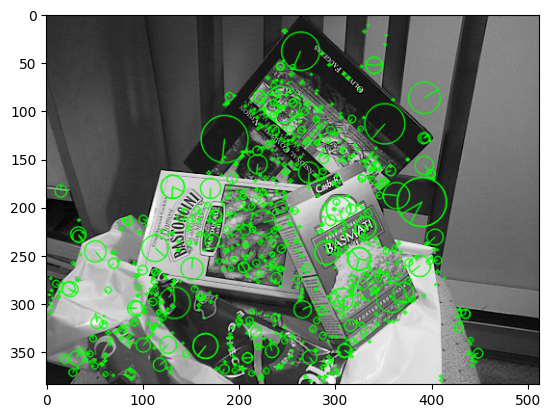

In [43]:
raw_image = cv.imread('box_in_scene.png', 0)
img1 = cv.drawKeypoints(raw_image, convertKeypointsToInputImageSize(keypoints_copy1), None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(keypoints_copy1))
import matplotlib.pyplot as plt
plt.imshow(img1, cmap='gray')

In [44]:
# 删除重复的关键点
def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

966


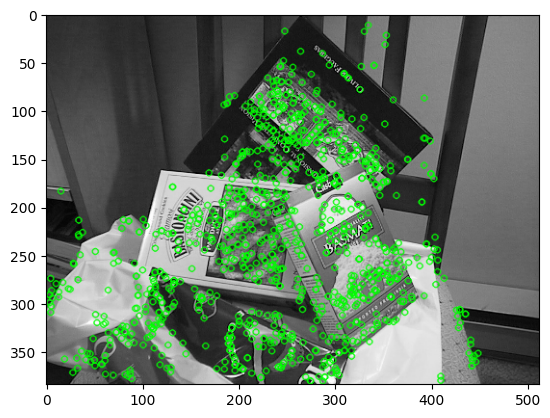

In [45]:
keypoint_remove = removeDuplicateKeypoints(keypoints_copy1)
print(len(keypoint_remove))
img2 = cv.drawKeypoints(raw_image, convertKeypointsToInputImageSize(keypoint_remove), None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
import matplotlib.pyplot as plt
plt.imshow(img2, cmap='gray')